In [ ]:
import torch
import torch.nn as nn
import torch.nn.functional as F
import torchvision
import torchvision.transforms as transforms
import numpy as np
import cv2
import matplotlib.pyplot as plt
import os
import pandas as pd
import tensorflow as tf

In [ ]:
from google.colab import drive
drive.mount('/content/drive')

Mounted at /content/drive


In [ ]:
path='/content/drive/MyDrive/SARS-COV-2_Ct-Scan_Dataset/'

In [ ]:
import pathlib
data = pathlib.Path(path)
count = len(list(data.glob('*/*.png')))
count

2481

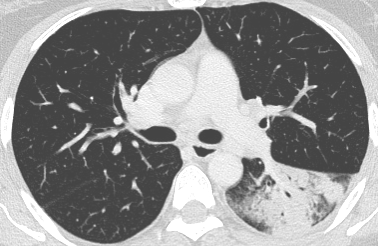

In [ ]:
import PIL
images=list(data.glob('*/*.png'))
PIL.Image.open(images[0])

In [ ]:
import os
import pandas as pd
types=['COVID', 'non-COVID']

dir=path

train_data = []

for index, val in enumerate(types):
    for file in os.listdir(os.path.join(dir, val)):
        train_data.append([val + "/" + file, index, val])

df = pd.DataFrame(train_data, columns = ['file', 'label','class'])

df

,file,label,class
0,COVID/Covid (221).png,0,COVID
1,COVID/Covid (206).png,0,COVID
2,COVID/Covid (214).png,0,COVID
3,COVID/Covid (175).png,0,COVID
4,COVID/Covid (245).png,0,COVID
...,...,...,...
2476,non-COVID/Non-Covid (1072).png,1,non-COVID
2477,non-COVID/Non-Covid (1039).png,1,non-COVID
2478,non-COVID/Non-Covid (119).png,1,non-COVID
2479,non-COVID/Non-Covid (1082).png,1,non-COVID


In [ ]:
df = df.sample(frac = 1, replace=False, random_state = 42)

In [ ]:
df = df.reset_index(drop = True)

In [ ]:
new_df = np.zeros((df.shape[0], 200, 200, 3))

In [ ]:
for index, file in enumerate(df['file'].values):
    image = cv2.imread(os.path.join(dir,file))
    if image is not None:
        new_df[index] = cv2.resize(image,(200,200),interpolation = cv2.INTER_AREA)

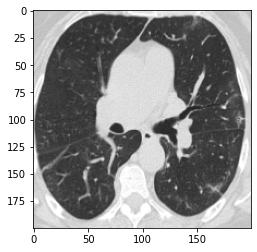

In [ ]:
plt.imshow(new_df[0].astype('uint8'))

In [ ]:
labels=df['label'].values

In [ ]:
type(new_df[0])

numpy.ndarray

In [ ]:
from sklearn.model_selection import train_test_split
X_train, X_test, Y_train, Y_test = train_test_split(new_df,
                                                  labels,
                                                  test_size = 0.2,
                                                  random_state = 42)

In [ ]:
X_train =  tf.convert_to_tensor(X_train)
X_test =  tf.convert_to_tensor(X_test)
Y_train =  tf.convert_to_tensor(Y_train)
Y_test =  tf.convert_to_tensor(Y_test)

In [ ]:
print(f'X_train:',X_train.shape)
print(f'X_val:',X_test.shape)
print(f'Y_train:',Y_train.shape)
print(f'Y_val:',Y_test.shape)

In [ ]:
import tensorflow as tf
base_model=tf.keras.applications.Xception(weights='imagenet',include_top=False, input_shape=(200, 200, 3))

83697664/83683744 [==============================] - 2s 0us/step


In [ ]:
base_model.summary()

Model: "xception"
__________________________________________________________________________________________________
 Layer (type)                   Output Shape         Param #     Connected to                     
 input_1 (InputLayer)           [(None, 200, 200, 3  0           []                               
                                )]                                                                
                                                                                                  
 block1_conv1 (Conv2D)          (None, 99, 99, 32)   864         ['input_1[0][0]']                
                                                                                                  
 block1_conv1_bn (BatchNormaliz  (None, 99, 99, 32)  128         ['block1_conv1[0][0]']           
 ation)                                                                                           
                                                                                           

In [ ]:
from keras.layers import Dense, GlobalAveragePooling2D, Dropout, Flatten
from keras.models import Model
from tensorflow.keras.optimizers import Adam

In [ ]:
base_model.trainable = False

In [ ]:
last_layer = base_model.get_layer('block14_sepconv2_act')
print(last_layer.output_shape)

(None, 7, 7, 2048)


In [ ]:
x = Flatten()(last_layer.output)
x = Dense(1024, activation = 'relu')(x)
x = Dropout(0.2)(x)
x = Dense(1, activation = 'sigmoid')(x)
model = Model(base_model.input, x)

In [ ]:
model.summary()

In [ ]:
optimizer = Adam(learning_rate=1e-6)
model.compile(optimizer=optimizer, loss='binary_crossentropy', metrics=['accuracy',tf.keras.metrics.Precision(),tf.keras.metrics.Recall(),])

In [ ]:
from keras.preprocessing.image import ImageDataGenerator

In [ ]:
datagen = ImageDataGenerator(vertical_flip = True, horizontal_flip=True) # Randomly flip inputs vertically and horizontally

In [ ]:
datagen.fit(X_train)

In [ ]:
X_train.shape[0]

1984

In [ ]:
from keras.callbacks import ModelCheckpoint, ReduceLROnPlateau
reducer = ReduceLROnPlateau(monitor='val_accuracy', factor=0.70, patience=5, verbose=1, min_lr=1e-4)
checkpoint = ModelCheckpoint('model.h5', verbose=1, save_best_only=True)

In [ ]:
print(X_train.dtype)
print(Y_train.dtype)
print(X_test.dtype)
print(Y_test.dtype)

<dtype: 'float64'>
<dtype: 'float32'>
<dtype: 'float64'>
<dtype: 'float32'>


In [ ]:
hist = model.fit(datagen.flow(X_train, Y_train, batch_size=64),
               steps_per_epoch=X_train.shape[0]//64 ,
               epochs=32,
               verbose=1,
               callbacks=[reducer, checkpoint],
               validation_data=(X_test, Y_test))

In [ ]:
plt.plot(hist.history['accuracy'])
plt.plot(hist.history['val_accuracy'])
plt.title('model accuracy')
plt.ylabel('accuracy')
plt.xlabel('epoch')
plt.legend(['train', 'test'], loc='upper left')
plt.show()

In [ ]:
plt.plot(hist.history['loss'])
plt.plot(hist.history['val_loss'])
plt.title('model loss')
plt.ylabel('loss')
plt.xlabel('epoch')
plt.legend(['train', 'test'], loc='upper left')
plt.show()